<a href="https://colab.research.google.com/github/gupta24789/sentiment-analysis/blob/main/bow_tfidf_ngram_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## We will explore below techniques

- BOW
- TFIDF
- N-Grams with bow and tfidf


In [1]:
!pip install neattext
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import itertools
import neattext as nt
from neattext.functions import clean_text
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

## Read Data

In [3]:
train_df = pd.read_csv("https://raw.githubusercontent.com/gupta24789/sentiment-analysis/main/data/train.csv")
val_df = pd.read_csv("https://raw.githubusercontent.com/gupta24789/sentiment-analysis/main/data/val.csv")

# train_df.processed_tweet = train_df.processed_tweet.fillna('[]').apply(lambda x: eval(x) if x is not None else [])
# val_df.processed_tweet = val_df.processed_tweet.fillna('[]').apply(lambda x: eval(x) if x is not None else [])

train_df = train_df[['raw_tweet','label']].dropna().reset_index(drop = True)
val_df = val_df[['raw_tweet','label']].dropna().reset_index(drop = True)

In [4]:
## Label distribution
train_df.label.value_counts()

1.0    4000
0.0    4000
Name: label, dtype: int64

In [5]:
train_df.head(3)

,raw_tweet,label
0,Want to say a huge thanks to @WarriorAssaultS ...,1.0
1,@jaynehh_ you just need a job and get a letter...,1.0
2,"@knhillrocks HA yes, make it quick tho :D",1.0


## Clean Text

In [6]:
train_df.raw_tweet.apply(lambda x: nt.TextFrame(x).noise_scan())

0       {'text_noise': 11.76470588235294, 'text_length...
1       {'text_noise': 14.17910447761194, 'text_length...
2       {'text_noise': 12.195121951219512, 'text_lengt...
3       {'text_noise': 17.56756756756757, 'text_length...
4       {'text_noise': 11.940298507462686, 'text_lengt...
                              ...                        
7995    {'text_noise': 17.582417582417584, 'text_lengt...
7996    {'text_noise': 29.411764705882355, 'text_lengt...
7997    {'text_noise': 13.953488372093023, 'text_lengt...
7998    {'text_noise': 16.842105263157894, 'text_lengt...
7999    {'text_noise': 36.36363636363637, 'text_length...
Name: raw_tweet, Length: 8000, dtype: object

In [7]:
train_df.raw_tweet.apply(lambda x: nt.TextFrame(x).count_stopwords())

0         {'to': 2, 'say': 1, 'a': 1, 'for': 1, 'the': 1}
1       {'you': 2, 'just': 1, 'a': 3, 'and': 2, 'get':...
2                                    {'make': 1, 'it': 1}
3       {'for': 1, 'me': 1, 'back': 1, 'not': 1, 'you'...
4                   {'out': 1, 'a': 1, 'for': 1, 'my': 1}
                              ...                        
7995                                            {'it': 1}
7996                                  {'why': 1, 'so': 1}
7997                                            {'to': 1}
7998    {'my': 1, 'were': 1, 'and': 1, 'there': 1, 'wa...
7999               {'why': 1, 'am': 1, 'i': 1, 'this': 1}
Name: raw_tweet, Length: 8000, dtype: object

In [8]:
## another way to clean the text
train_df.raw_tweet.apply(lambda x: nt.TextCleaner(clean_text(x, puncts=True,
                                                stopwords=True,
                                                urls=True,
                                                emails=True,
                                                numbers=True,
                                                emojis=False,
                                                special_char=False,
                                                phone_num=True,
                                                non_ascii=False,
                                                multiple_whitespaces=True,
                                                contractions=False,
                                                currency_symbols=False,
                                                custom_pattern=None)).remove_userhandles().remove_multiple_spaces())

0                  want huge thanks #ff thanks support :)
1        need job letter work place saying work letter...
2                                     ha yes quick tho :d
3              thanks texting :)) im texting tomorrow :))
4       laying greetings card range print today love j...
                              ...                        
7995     im watching madrid leads supersport aint show...
7996                                           sudden :((
7997                       :((( bout instant transmission
7998            feet cold point taking socks okay stop :(
7999                             oppa/hug ur arm/ like :(
Name: raw_tweet, Length: 8000, dtype: object

In [9]:
def custom_clean_text(x):
  x = nt.TextFrame(x)
  x = x.remove_stopwords().remove_urls().remove_emails().remove_dates().remove_puncts().remove_numbers().remove_userhandles().remove_multiple_spaces()
  x = x.text.lower()
  return x

In [10]:
train_df['processed_text'] = train_df.raw_tweet.apply(lambda x: custom_clean_text(x))
val_df['processed_text'] = val_df.raw_tweet.apply(lambda x: custom_clean_text(x))

In [11]:
train_df.head(3)

,raw_tweet,label,processed_text
0,Want to say a huge thanks to @WarriorAssaultS ...,1.0,want huge thanks #ff thanks support :)
1,@jaynehh_ you just need a job and get a letter...,1.0,need job letter work place saying work letter...
2,"@knhillrocks HA yes, make it quick tho :D",1.0,ha yes quick tho :d


In [12]:
X_train = train_df.processed_text
y_train = train_df.label

X_val = val_df.processed_text
y_val = val_df.label

## Most common words for positive and negative class

In [14]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

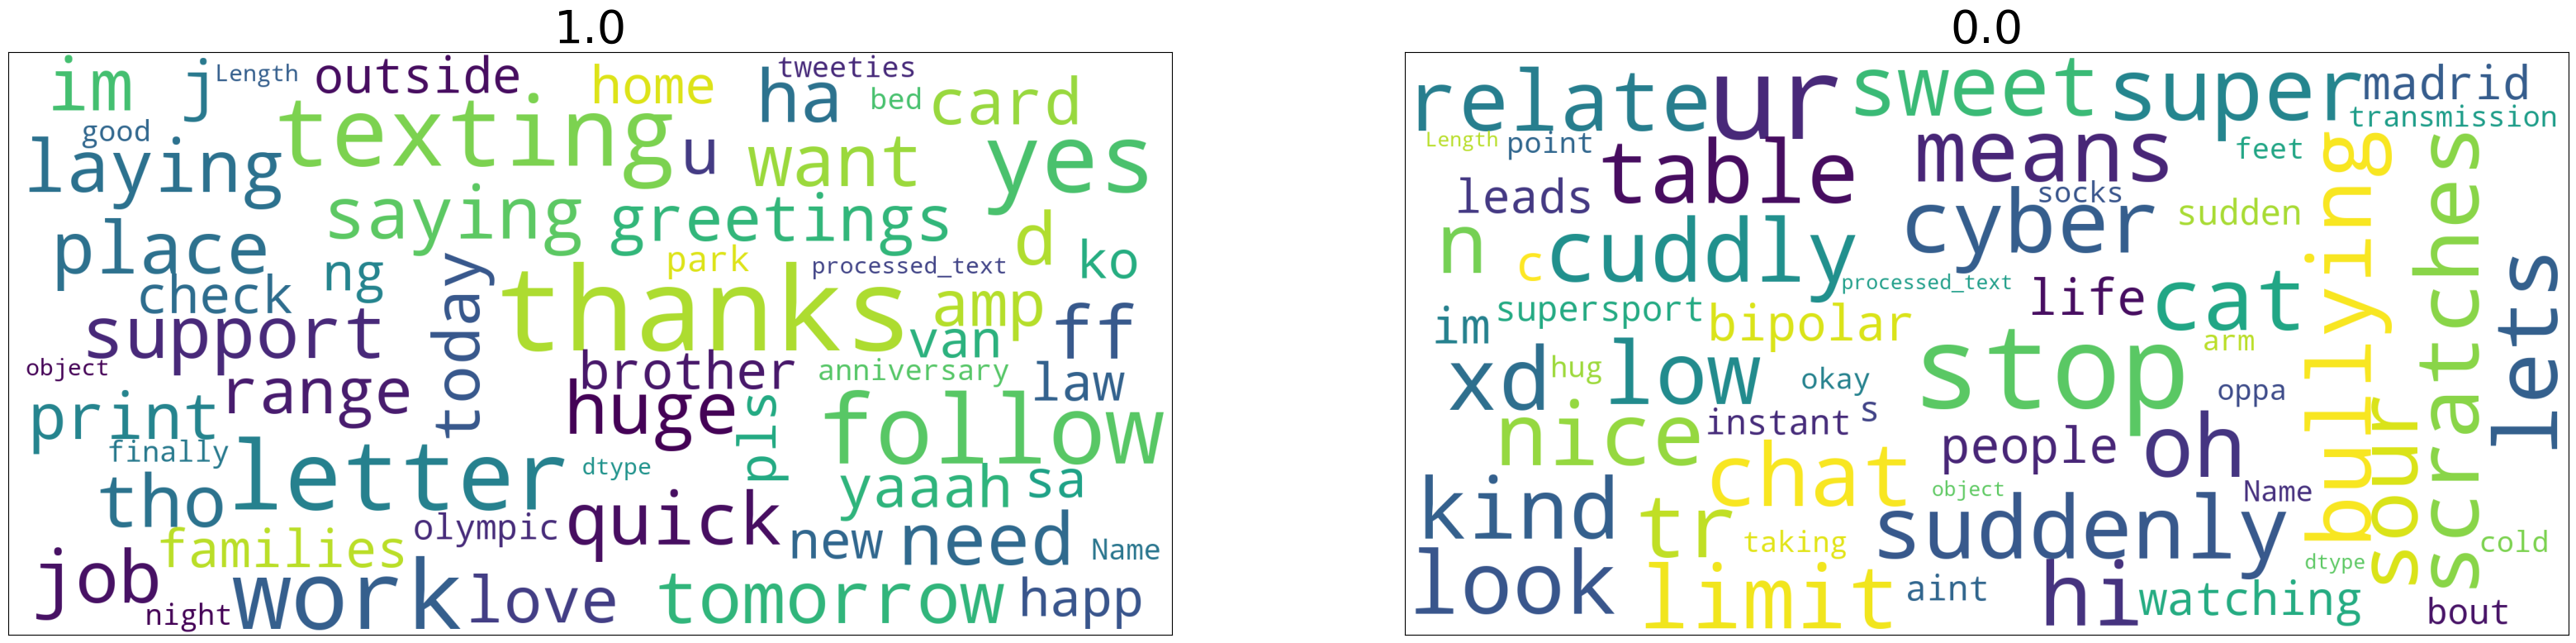

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(40,20))

for index, col in enumerate(train_df['label'].unique()):
    plt.subplot(1,2, index+1)
    # print(col)
    df1 = train_df[train_df['label']==col].copy()
    data = df1['processed_text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)

plt.show()
plt.tight_layout()

## BOW

In [16]:
sample_tweet = train_df.processed_text[0]
print(sample_tweet)

want huge thanks #ff thanks support :)


In [17]:
vectorizer = CountVectorizer(lowercase=True, ngram_range = (1,1))
vectorizer

CountVectorizer()

In [18]:
processed_tweet = vectorizer.fit_transform([sample_tweet])
print(processed_tweet.toarray())
print(vectorizer.vocabulary_)

[[1 1 1 2 1]]
{'want': 4, 'huge': 1, 'thanks': 3, 'ff': 0, 'support': 2}


In [19]:
## Lets create the pipeline usign BOW
classifier = Pipeline([
    ('count_vectorizer', CountVectorizer(lowercase=True, ngram_range = (1,1))),
    ('bow_model', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

In [20]:
classifier.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('bow_model', RandomForestClassifier(n_jobs=-1))])

In [21]:
y_pred = classifier.predict(X_val)

In [22]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1000
           1       0.77      0.68      0.72      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



In [23]:
input_text = 'i love this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([0.])

In [24]:
input_text = 'i hate this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([0.])

## BOW using ngram

In [25]:
vectorizer = CountVectorizer(lowercase=True, ngram_range = (1,2))

In [26]:
processed_tweet = vectorizer.fit_transform([sample_tweet])
print(processed_tweet.toarray())
print(vectorizer.vocabulary_)

[[1 1 1 1 1 2 1 1 1 1]]
{'want': 8, 'huge': 2, 'thanks': 5, 'ff': 0, 'support': 4, 'want huge': 9, 'huge thanks': 3, 'thanks ff': 6, 'ff thanks': 1, 'thanks support': 7}


In [27]:
## Model building
classifier = Pipeline([
    ('count_vectorizer', CountVectorizer(lowercase=True, ngram_range = (1,2))),
    ('bow_model', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

classifier.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('bow_model', RandomForestClassifier(n_jobs=-1))])

In [28]:
y_pred = classifier.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.82      0.76      1000
           1       0.78      0.65      0.71      1000

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.74      0.73      0.73      2000



In [29]:
input_text = 'i love this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([0.])

In [30]:
input_text = 'i hate this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([0.])

## TFIDF

In [41]:
vectorizer = TfidfVectorizer(lowercase=True, ngram_range = (1,1))
vectorizer

TfidfVectorizer()

In [42]:
processed_tweet = vectorizer.fit_transform([sample_tweet])
print(processed_tweet.toarray())
print(vectorizer.vocabulary_)

[[0.35355339 0.35355339 0.35355339 0.70710678 0.35355339]]
{'want': 4, 'huge': 1, 'thanks': 3, 'ff': 0, 'support': 2}


In [46]:
vectorizer = TfidfVectorizer(lowercase=True, ngram_range = (1,1), max_df = 2, min_df= 2)
vectorizer

TfidfVectorizer(max_df=2, min_df=2)

In [47]:
## Model building
classifier = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, ngram_range = (1,1))),
    ('tfidf_model', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

classifier.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', TfidfVectorizer()),
                ('tfidf_model', RandomForestClassifier(n_jobs=-1))])

In [48]:
y_pred = classifier.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75      1000
           1       0.77      0.67      0.72      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



In [49]:
input_text = 'i love this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([1.])

In [50]:
input_text = 'i hate this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([0.])

## IFTDF with ngram

In [51]:
vectorizer = TfidfVectorizer(lowercase=True, ngram_range = (1,2))
vectorizer

TfidfVectorizer(ngram_range=(1, 2))

In [52]:
processed_tweet = vectorizer.fit_transform([sample_tweet])
print(processed_tweet.toarray())
print(vectorizer.vocabulary_)

[[0.2773501 0.2773501 0.2773501 0.2773501 0.2773501 0.5547002 0.2773501
  0.2773501 0.2773501 0.2773501]]
{'want': 8, 'huge': 2, 'thanks': 5, 'ff': 0, 'support': 4, 'want huge': 9, 'huge thanks': 3, 'thanks ff': 6, 'ff thanks': 1, 'thanks support': 7}


In [57]:
vectorizer = TfidfVectorizer(lowercase=True, ngram_range = (1,2), min_df = 2, max_df = 5)
vectorizer

TfidfVectorizer(max_df=5, min_df=2, ngram_range=(1, 2))

In [58]:

## Model building
classifier = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, ngram_range = (1,2))),
    ('tfidf_model', RandomForestClassifier(n_estimators=100, n_jobs=-1))
])

classifier.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('tfidf_model', RandomForestClassifier(n_jobs=-1))])

In [59]:
y_pred = classifier.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1000
           1       0.78      0.68      0.72      1000

    accuracy                           0.74      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.74      0.74      2000



In [60]:
input_text = 'i love this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([1.])

In [61]:
input_text = 'i hate this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([0.])

In [62]:
## Save model
import pickle

pickle.dump(classifier, open('model.pkl', 'wb'))

In [63]:
classifier = pickle.load(open('model.pkl', 'rb'))

In [64]:
input_text = 'i hate this movie'
clean_input_text = custom_clean_text(input_text)
classifier.predict([clean_input_text])

array([0.])